In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import collections

## Load query text

In [2]:
def _read_collections(filename):
    with open(filename) as f:
        id_2_text = {}
        for line in f:
            id, text = line.strip().split("\t")
            id_2_text[id] = text

    print(f"there are {len(id_2_text)} entries in the collection {filename}")
    return id_2_text

In [3]:
query_collection = '/home/ubuntu/MLData/work/Repos/NeuralIR/data/collectionandqueries/queries.dev.small.tsv'
qid_2_query = _read_collections(query_collection)
print(len(qid_2_query))
    

there are 6980 entries in the collection /home/ubuntu/MLData/work/Repos/NeuralIR/data/collectionandqueries/queries.dev.small.tsv
6980


## Load Sentence Bert

In [4]:
from sentence_transformers import SentenceTransformer, util

In [5]:
embedder = SentenceTransformer('msmarco-distilbert-dot-v5')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']


In [6]:
sen_embedder = SentenceTransformer('msmarco-distilbert-dot-v5')

queries = list(qid_2_query.values())
qids = list(qid_2_query.keys())

embeddings = sen_embedder.encode(queries, convert_to_tensor=True).cpu().numpy()

In [7]:
embeddings.shape

(6980, 768)

(6980,)


(array([ 100.,  607., 1612., 1965., 1441.,  824.,  311.,   83.,   28.,
           9.]),
 array([ 8.934281,  9.062391,  9.190502,  9.318613,  9.446723,  9.574833,
         9.702944,  9.831055,  9.959165, 10.087275, 10.215385],
       dtype=float32),
 <BarContainer object of 10 artists>)

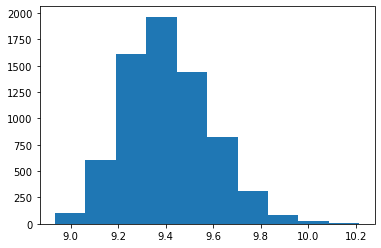

In [8]:
lengths = np.linalg.norm(embeddings, axis=1)
print(lengths.shape)
plt.hist(lengths)

## Visualization

In [33]:
from sklearn.manifold import TSNE
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [9]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=5, 
                            metric='euclidean').fit_transform(embeddings)

In [10]:
import joblib, six
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [11]:
print(len(cluster.labels_))
print(cluster.labels_[:100])
# negative number -1 indicates that the point does not belong to a cluster has min size of 15


6980
[-1 -1 -1 21 27  3 20 21 -1  0 17 21 21 -1 21 -1 -1 -1 12 21  3 19 19 -1
 18 -1 12 27  3 21 -1 -1 19 -1 -1 19  8 12 -1  3  8 -1 27 19 21 -1 12 21
 12 -1 -1 19 21 12 19 21 14 12 21 19  4 27 16 21 12  3 19 27 21 21 21 21
 21 21 -1 12 16 14 27 -1 -1 26  3 -1 21 21  3 21 21 21 -1 19 14 21 27 21
 19 21 28 19]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



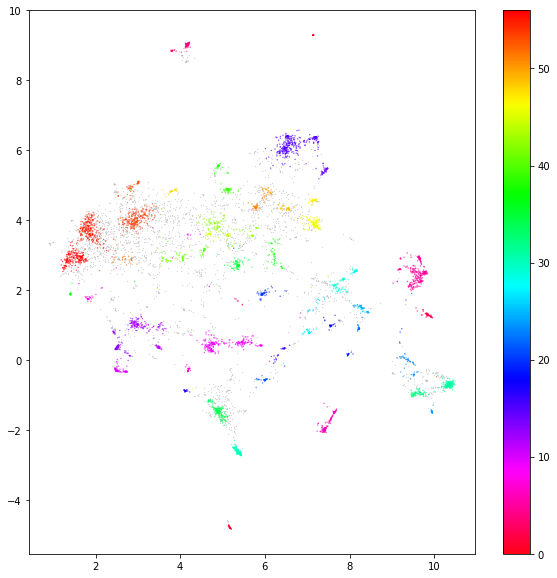

In [47]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.1, cmap='hsv_r')
plt.colorbar()

In [17]:
unique_labels = set(cluster.labels_)
label_2_query = collections.defaultdict(list)
label_2_qid = collections.defaultdict(list)
qid_2_label = {}

for idx, q in enumerate(queries):
    label = cluster.labels_[idx]
    qid_2_label[qids[idx]] = int(label)
    if label > 0:
        label_2_query[label].append(q)
        label_2_qid[int(label)].append(qids[idx])

for i in range(1, 10):
    print(label_2_qid[i][:3])
    print(label_2_query[i][:3])
    
print(qid_2_query['548254'])
import json
with open('qid_2_cluster_label.json', 'w') as file:
    json.dump(qid_2_label, file)

with open('cluster_label_2_qid.json', 'w') as file:
    json.dump(label_2_qid, file)

# ['wenatchee washington population', 'city of richmond ky population', 'wright city mo population']
# ['average temp in hana hi', 'what is average wet bulb temp', 'average temperatures des moines iowa']
# ['community bank bristow routing number', 'alabama central credit union routing number', 'colorado routing number loveland colorado']
# ['tricare service number', 'trumbull marriott fax number', 'usaa home insurance phone number']
# ['how long is a day on ven', 'how long is a typical car loan?', 'how long is flight from hyd to dubai']
# ['when he was born ben franklin', 'can you tell me where the actor william devane was born', 'origination of pi day']
# ['acute myelogenous leukemia age', 'age and weight requirements for children to sit in the front seat', 'age discrimination in the workplace cases']
# ['what fraction of the light falling on a piece of photographic film is typically wasted', 'percentage of people with security clearance', 'how many percent of people worldwide have vitiligo']
# ["who's voice come from?", '_______ sediments originate from elements in seawater that precipitate out of solution.', 'where do hormones come from']

['548254', '1072750', '1080537']
['wenatchee washington population', 'city of richmond ky population', 'wright city mo population']
['44686', '1060795', '45757']
['average temp in hana hi', 'what is average wet bulb temp', 'average temperatures des moines iowa']
['786674', '524848', '1049774']
['what is prime rate in canada', 'trivex lenses cost', 'cost of attendance eastern illinois university']
['437291', '1079888', '1079959']
['largest shipping day of year', "world's largest goldfish on record", "world's most poisonous snakes in the world"]
['1077844', '572978', '1079535']
['what information do i need to get a home loan', 'what are the requirement to join the coast guards', 'what grade on final do i need']
['275137', '275534', '281930']
['how many babies in a chipmunk birth?', 'how many books did montag steal', 'how many dead bodies on everest']
['613727', '1063478', '548475']
['what county is toledo oh in?', 'columbus texas is in what county', 'westborough local history librarian']

In [19]:
easy_clusters = [1, 8]
hard_clusters = [12, 23]

for i in easy_clusters:
    print(label_2_query[i][:3])

for i in hard_clusters:
    print(label_2_query[i][:3])

['wenatchee washington population', 'city of richmond ky population', 'wright city mo population']
['twin tower adress', 'two rivers supervisory union', 'wedding venues in dallas']
['how long is a day on ven', 'how long is a typical car loan?', 'how long is flight from hyd to dubai']
['mandibular functions', 'what is a sulfur atom', 'are schwann cells are glial cells of the central nervous system']
